# 0. T5_NER_Catalogue

**1. Setup**
- 1.1 Library
- 1.2 Dataset
- 1.3 Preprocessing

**2. Model**
- 2.1 Train & Validate Function
- 2.2 Evaluation

**3. Main Experiments**
- 3.1 Train & Validate
- -(Full tags: lr=10*(-4), batch_size=32 -> TL1_2, DL1_2, DA1_2, DF1_2)
- -(Simple tags: lr=10*(-4), batch_size=32 -> TL2_1, DL2_1, DA2_1, DF2_1)
- 3.2 Test & OOD 

# 1. Setup

## 1-1. Library 

In [2]:
from random import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoModel, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import T5ForConditionalGeneration
import datasets

from tqdm.auto import tqdm

In [3]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
from collections import defaultdict, Counter
from urllib import request
import json
import pandas as pd

In [5]:
import os
import matplotlib.pyplot as plt
from glob import glob
from math import floor, ceil, log10

## 1-2. Dataset

In [6]:
# "json.load" will turn all tuples into list
with open('ner_data_dict.json', 'r', encoding='utf-8') as f:
    data_dict = json.load(f)

In [7]:
# Each subset of each corpus is a list of tuples where each tuple
# is a list of tokens with a corresponding list of labels.

# Train on data_dict['en_ewt']['train']; validate on data_dict['en_ewt']['dev']
# and test on data_dict['en_ewt']['test'] and data_dict['en_pud']['test']
Train = data_dict['en_ewt']['train']
Validate = data_dict['en_ewt']['dev']
Test = data_dict['en_ewt']['test']
OOD = data_dict['en_pud']['test']

In [8]:
def simplify_tag(dataset):
    # Simplify the 7 types of tags to B/I/O tags 
    simple = []
    def simplify(full_tag):
        ## Simplify the single full_tag
        if full_tag == "O":
            return "O"
        return full_tag.split("-", 1)[0] ## "B-LOC" -> "B"
    
    ## Extract and simplify the tag sequence 
    for sentence, tag in dataset:
        simple_tag = [simplify(t) for t in tag]
        simple.append([sentence, simple_tag])
    
    return simple

In [9]:
Simple_Train = simplify_tag(Train)
Simple_Validate = simplify_tag(Validate)
Simple_Test = simplify_tag(Test)
Simple_OOD = simplify_tag(OOD)

In [10]:
def tag_info(dataset):
    tags = set()
    for sent in dataset:
        # Extract the tags
        tags.update([tag for tag in sent[1]])
        num_class = len(tags)
    return tags, num_class

In [11]:
tag_set, num_class = tag_info(Train)
simple_tag_set, simple_class = tag_info(Simple_Train)

In [12]:
tag_to_i = {
    tag: i
    for i, tag in enumerate(sorted(tag_set))
}
i_to_tag = {
    i: tag
    for tag, i in tag_to_i.items()
}

In [13]:
simple_tag_to_i = {
    tag: i
    for i, tag in enumerate(sorted(simple_tag_set))
}
i_to_simple_tag = {
    i: tag
    for tag, i in simple_tag_to_i.items()
}

## 1-3. Preprocessing

In [14]:
def extract_spans(tags):
    spans = []
    current = None  # Store the current span

    for idx, tag in enumerate(tags):
        # 1. Exclude "O"
        if tag == "O":
            if current:
                spans.append([current[0], current[1], current[2]]) ## add the whole span to the list
                current = None ## Clear the current span 
        else:
            # 1. Split the tag to distinguish full types from simple types
            if "-" in tag:
                prefix, label = tag.split("-", 1)
            else:
                prefix, label = tag, None
            # 2. Process different tags    
            if prefix == "B":
                if current:  
                    spans.append([current[0], current[1], current[2]]) ## Save the last span
                current = [idx, idx, tag]  ## Start a new span: [start, end, tag]
            elif prefix == "I":
                if current:
                    current[1] = idx ## Update the end_idx
                else:
                    if current:
                        spans.append([current[0], current[1], current[2]])
                    current = None
    
    # Check the last tag after the loop ends
    if current:
        spans.append([current[0], current[1], current[2]])
    
    return spans

In [15]:
def span_dataset(dataset):
    spans = []
    for sent in dataset:
        current_span = extract_spans(sent[1])
        spans.append(current_span)
    return spans

In [16]:
Span_Validate = span_dataset(Validate)
Span_Test = span_dataset(Test)
Span_OOD = span_dataset(OOD)

In [17]:
def Prepare_F1score(pred_spans, gold_spans, labelled=True):
    TP = FP = FN = 0
    
    for p_spans, g_spans in zip(pred_spans, gold_spans):
        if labelled:
            pred = [tuple(s) for s in p_spans]
            gold = [tuple(s) for s in g_spans]
        else:
            pred = [(start, end) for (start, end, _) in p_spans]
            gold = [(start, end) for (start, end, _) in g_spans]

        # Copy a gold_spans
        gold_copy = gold.copy()


        for span in pred:
            if span in gold_copy:
                TP += 1
                gold_copy.remove(span)
            else:
                FP += 1
        FN += len(gold_copy)
        
    return TP, FP, FN

# 2. Model

## 2-1. Train & Validate Function

In [18]:
def process_batch_T5(batch_inputs, batch_labels,
                  tokeniser, model, device,
                  optimiser, max_len=256):
    # Exactly the same code as before.
    optimiser.zero_grad()
    tokenisation = tokeniser(
        batch_inputs,
        return_tensors='pt',
        max_length=max_len,
        padding='longest',
        truncation=True
    )
    input_ids = tokenisation.input_ids.to(device)
    attention_mask = tokenisation.attention_mask.to(device)
    labels = tokeniser(
        batch_labels,
        return_tensors='pt',
        max_length=max_len,
        padding='longest',
        truncation=True
    ).input_ids.to(device)
    # Stop the model from generating pad tokens
    labels[labels == tokeniser.pad_token_id] = -100
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }
    loss = model(**inputs).loss
    loss.backward()
    optimiser.step()
    return loss.item()

In [19]:
def prepare_T5(sentence_pair):
    words, labels = sentence_pair
    prompt = ("Sentence:\n" +
              " ".join(words) + "\n" +
              "Tags:")
    # prompt = f"Sentence: {' '.join(words)}\nLabel tokens:"
    # prompt = "NER: " + ' '.join(words) 
    # prompt = f"Sentence: {' '.join(words)} [SEP] label each token with its entity type:"
    label = ' '.join(labels)
    return prompt, label

In [20]:
few_shot = [(["Dmitry", "went", "to", "Moscow", "."], ["B-PER", "O", "O", "B-LOC", "O"]),
    (["Colin",   "has", "a", "dog", "."], ["B-PER", "O",  "O",  "O",  "O"])]

In [21]:
def prepare_T5_fewshot(sentence_pair):
    words, labels = sentence_pair

    shot_lines = []
    for ex_words, ex_labels in few_shot:
        shot_lines.append("Sentence:")
        shot_lines.append(" ".join(ex_words))
        shot_lines.append("Tags: " + " ".join(ex_labels))
        shot_lines.append("") 

    shot_lines.append("Sentence:")
    shot_lines.append(" ".join(words))
    shot_lines.append("Tags:")  

    prompt = "\n".join(shot_lines)
    label  = " ".join(labels)   

    return prompt, label

In [22]:
def train_epoch_T5(train_inputs, batch_size,
                   tokeniser, model, device, optimizer):
    model.train()
    
    n_steps = ceil(len(train_inputs) / batch_size)
    epoch_losses = torch.zeros(n_steps)
    for step_n in tqdm(range(n_steps), leave=False, desc='Train'):
        lo = step_n * batch_size
        hi = lo + batch_size
        batch_inputs = train_inputs[lo:hi]
        
        batch_texts, batch_labels = zip(*(prepare_T5_fewshot(ex) for ex in batch_inputs))
        loss = process_batch_T5(list(batch_texts), list(batch_labels),
                                tokeniser, model, device, optimizer)
        epoch_losses[step_n] = loss
    return epoch_losses.mean().item()

In [23]:
# def compare_loss(prompt, tokeniser, model, device, 
#                          candidate_class, max_len=512):
#     tokenisation = tokeniser(
#         prompt,
#         return_tensors='pt',
#         max_length=max_len,
#         truncation=True
#     )
#     input_ids = tokenisation.input_ids.to(device)
#     attention_mask = tokenisation.attention_mask.to(device)
#     loss_ls=[]
#     # Contrast likelihoods of possible labels
#     with torch.no_grad():
#         for i in candidate_class:
#             label_ids = tokeniser(i, return_tensors='pt').input_ids.to(device)
#             loss = model(input_ids=input_ids, attention_mask=attention_mask,
#                         labels=label_ids).loss.item()
#             loss_ls.append(loss)
#     best_idx = loss_ls.index(min(loss_ls))
#     return candidate_class[best_idx]

In [24]:
# def get_likelihood(prompts, labels, tokeniser, model, device, max_len=256):
#     enc = tokeniser(
#         prompts,
#         return_tensors='pt',
#         max_length=max_len,
#         padding="longest",
#         truncation=True
#     ).to(device)
    
#     dec = tokeniser(
#         labels,
#         return_tensors="pt",
#         padding="longest",
#         truncation=True,
#         max_length=max_len
#     ).to(device)
    
#     outputs = model(input_ids=enc.input_ids,
#                    attention_mask=enc.attention_mask,
#                    labels=dec.input_ids)
    
#     logits = outputs.logits # [batch, seq_len, vocab_size]
#     # pred_logprobs = F.log_softmax(logits, dim=-1)
#     pred_ids = logits.argmax(dim=-1).cpu().tolist() # [batch, seq_len]

#     return logits, pred_ids

In [25]:
def generate_prediction(prompts, tokeniser, model, device, max_len=256):
    enc = tokeniser(
        prompts,
        return_tensors='pt',
        max_length=max_len,
        padding="longest",
        truncation=True
    )
    input_ids = enc.input_ids.to(device)
    attention_mask = enc.attention_mask.to(device)
    
    pred_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_len,
            num_beams=3,
            early_stopping=True)
    
    return pred_ids

In [26]:
def validate_epoch_T5(dev_inputs, batch_size,
                       tokeniser, model, device, max_len=256):
    model.eval()
    all_TP =  all_FP = all_FN = 0
    
    n_steps = ceil(len(dev_inputs) / batch_size)
    for step_n in tqdm(range(n_steps), leave=False, desc='Validate'):
        # The preprocessing described above
        lo = step_n * batch_size
        hi = lo + batch_size
        batch_inputs = dev_inputs[lo:hi] 
        batch_texts, batch_labels = zip(*(prepare_T5_fewshot(ex) for ex in batch_inputs))
        
        with torch.no_grad():
            # logits, pred_ids = get_likelihood(batch_texts, batch_labels, 
            #                                   tokeniser, model, device, max_len=512)
            pred_ids = generate_prediction(batch_texts, tokeniser, model, device, max_len=256)
            pred_texts = tokeniser.batch_decode(pred_ids, skip_special_tokens=True)
            pred_tags = [text.split() for text in pred_texts]
            
            # if step_n == 0:
            #     print("pred tags", pred_tags[0])
            
            pred_spans = [extract_spans(tags) for tags in pred_tags]
            gold_spans = [extract_spans(tag_str.split()) for tag_str in batch_labels]
            
            # if step_n == 0:
            #     print("gold spans", gold_spans[0])
            #     print("pred spans", pred_spans[0])
                
            TP, FP, FN = Prepare_F1score(pred_spans, gold_spans, labelled=True)
            # print("Batch TP/FP/FN", TP, FP, FN)
            all_TP += TP
            all_FP += FP
            all_FN += FN
            
    Precision = all_TP / (all_TP + all_FP) if (all_TP + all_FP) > 0 else 0.0
    Recall = all_TP / (all_TP + all_FN) if (all_TP + all_FN) > 0 else 0.0
    F1 = (2 * Precision * Recall / (Precision + Recall)) if (Precision + Recall) > 0 else 0.0
    
    return Precision, Recall, F1

In [27]:
def main_T5(train_data, dev_data,
            tokeniser, model, device, n_epochs, 
            lr, early_stop, batch_size): # , candidate_class
    
    optim = torch.optim.AdamW(list(model.parameters()), lr=lr)
    
    lr_string = abs(int(log10(lr)))
    
    best_F1 = 0.0
    last_improvement = 0
    train_losses = []
    dev_Precision = []
    dev_Recall = []
    dev_F1 = []
    
    for epoch in tqdm(range(n_epochs)):
        
        train_loss = train_epoch_T5(train_data, batch_size,
                                    tokeniser, model, device, optim)
        train_losses.append(train_loss)
        
        P, R, F1 = validate_epoch_T5(dev_data, batch_size,
                                     tokeniser, model, device, max_len=256)
        
        dev_Precision.append(P)
        dev_Recall.append(R)
        dev_F1.append(F1)

        print(f'Epoch {epoch:2d}, train loss: {train_loss:.3f}; dev F1: {F1:.3f}; dev Precision: {P:.3f}, dev Recall: {R:.3f}')
        
        if F1 > best_F1:
            print('Saving the model')
            best_F1 = F1
            last_improvement = epoch

            # for path in glob('*.pt'):
            #     os.remove(path)
            # torch.save({'model': model.state_dict()},
            #            f'T5_Full_epoch{epoch:02d}_{lr_string}.pt')
            torch.save({'model': model.state_dict()},
                       f'T5_Simple_epoch{epoch:02d}_{lr_string}.pt')
        else:
            if epoch - last_improvement >= early_stop:
                print(f'Early stopping: no improvement for {early_stop} epochs.')
                break
    
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.plot(dev_F1, label='Dev F1')
    plt.plot(dev_Precision, label='Dev Precision')
    plt.plot(dev_Recall, label='Dev Recall')
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, dev_F1

In [28]:
# def validate_epoch_likelihood_T5(dev_inputs, batch_size,
#                        tokeniser, model, device, max_len=256):
#     model.eval()
#     all_TP =  all_FP = all_FN = 0
    
#     n_steps = ceil(len(dev_inputs) / batch_size)
#     for step_n in tqdm(range(n_steps), leave=False, desc='Validate'):
#         # The preprocessing described above
#         lo = step_n * batch_size
#         hi = lo + batch_size
#         batch_inputs = dev_inputs[lo:hi] 
#         batch_texts, batch_labels = zip(*(prepare_T5_fewshot(ex) for ex in batch_inputs))
        
#         with torch.no_grad():
#             logits, pred_ids = get_likelihood(batch_texts, batch_labels, 
#                                               tokeniser, model, device, max_len=512)
#             pred_texts = tokeniser.batch_decode(pred_ids, skip_special_tokens=True)
#             pred_tags = [text.split() for text in pred_texts]
            
#             # if step_n == 0:
#             #     print("pred tags", pred_tags[0])
            
#             pred_spans = [extract_spans(tags) for tags in pred_tags]
#             gold_spans = [extract_spans(tag_str.split()) for tag_str in batch_labels]
            
#             # if step_n == 0:
#             #     print("gold spans", gold_spans[0])
#             #     print("pred spans", pred_spans[0])
                
#             TP, FP, FN = Prepare_F1score(pred_spans, gold_spans, labelled=True)
#             # print("Batch TP/FP/FN", TP, FP, FN)
#             all_TP += TP
#             all_FP += FP
#             all_FN += FN
            
#     Precision = all_TP / (all_TP + all_FP) if (all_TP + all_FP) > 0 else 0.0
#     Recall = all_TP / (all_TP + all_FN) if (all_TP + all_FN) > 0 else 0.0
#     F1 = (2 * Precision * Recall / (Precision + Recall)) if (Precision + Recall) > 0 else 0.0
    
#     return Precision, Recall, F1

In [29]:
# def main_T5_likelihood(train_data, dev_data,
#                         tokeniser, model, device, n_epochs, 
#                         lr, early_stop, batch_size): 
    
#     optim = torch.optim.AdamW(list(model.parameters()), lr=lr)
    
#     lr_string = abs(int(log10(lr)))
    
#     best_F1 = 0.0
#     last_improvement = 0
#     train_losses = []
#     dev_Precision = []
#     dev_Recall = []
#     dev_F1 = []
    
#     for epoch in tqdm(range(n_epochs)):
        
#         train_loss = train_epoch_T5(train_data, batch_size,
#                                     tokeniser, model, device, optim)
#         train_losses.append(train_loss)
        
#         P, R, F1 = validate_epoch_likelihood_T5(dev_data, batch_size,
#                                      tokeniser, model, device, max_len=256)
        
#         dev_Precision.append(P)
#         dev_Recall.append(R)
#         dev_F1.append(F1)

#         print(f'Epoch {epoch:2d}, train loss: {train_loss:.3f}; dev F1: {F1:.3f}; dev Precision: {P:.3f}, dev Recall: {R:.3f}')
        
#         if F1 > best_F1:
#             print('Saving the model')
#             best_F1 = F1
#             last_improvement = epoch

#             # for path in glob('*.pt'):
#             #     os.remove(path)
#             torch.save({'model': model.state_dict()},
#                        f'T5_Full_liklihood_epoch{epoch:02d}_{lr_string}.pt')
#         else:
#             if epoch - last_improvement >= early_stop:
#                 print(f'Early stopping: no improvement for {early_stop} epochs.')
#                 break
    
#     plt.plot(train_losses, label='Train Loss')
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     plt.plot(dev_F1, label='Dev F1')
#     plt.plot(dev_Precision, label='Dev Precision')
#     plt.plot(dev_Recall, label='Dev Recall')
#     plt.xlabel("Epochs")
#     plt.ylabel("Score")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return train_losses, dev_F1

## 2-2. Evaluation

In [30]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [31]:
def evaluation_T5(test_inputs, tokeniser, model, device, tag_to_i, batch_size=32):
    
    model.eval()
    all_preds, all_golds = [], []
    all_pred_spans, all_gold_spans = [], []
    
    n_steps = ceil(len(test_inputs) / batch_size)
    for step_n in tqdm(range(n_steps), leave=False, desc='Test'):
        # The preprocessing described above
        lo = step_n * batch_size
        hi = lo + batch_size
        batch_inputs = test_inputs[lo:hi] 
        batch_texts, batch_labels = zip(*(prepare_T5_fewshot(ex) for ex in batch_inputs))
        gold_tags = [tags.split() for tags in batch_labels]
        
        with torch.no_grad():
            pred_ids = generate_prediction(batch_texts, tokeniser, model, device, max_len=256)
            pred_texts = tokeniser.batch_decode(pred_ids, skip_special_tokens=True)
            pred_tags = [text.split() for text in pred_texts]
            
            class_type = set(tag_to_i.keys())
            aligned_preds = []
            for (pt, gt), (words, _) in zip(zip(pred_tags, gold_tags), batch_inputs):
                seq_len = len(words)
                if len(pt) > seq_len:
                    pt = pt[:seq_len]
                elif len(pt) < seq_len:
                    pt = pt + ["O"]*(seq_len - len(pt))
                pt = [t if t in class_type else "O" for t in pt]
                aligned_preds.append(pt)
            
            all_preds.extend(aligned_preds)
            all_golds.extend(gold_tags)
            all_pred_spans.extend(extract_spans(tags) for tags in pred_tags)
            all_gold_spans.extend(extract_spans(tags) for tags in gold_tags)

    # Matching score = Recall = TP / (TP + FN) 
    ## (correctly matching gold spans)/(gold spans)
    tp_l, fp_l, fn_l = Prepare_F1score(all_pred_spans, all_gold_spans, labelled=True)
    tp_u, fp_u, fn_u = Prepare_F1score(all_pred_spans, all_gold_spans, labelled=False)

    match_labelled   = tp_l / (tp_l + fn_l) if tp_l + fn_l else 0.0
    match_unlabelled = tp_u / (tp_u + fn_u) if tp_u + fn_u else 0.0

    metric_result = classification_report(all_golds, all_preds, output_dict=True, zero_division=0)
    
    # P/R/F1
    types = [t for t in metric_result if t not in {"micro avg", "macro avg", "weighted avg"}]
    each_tag = {t: {"precision": metric_result[t]["precision"],
                    "recall": metric_result[t]["recall"],
                    "f1": metric_result[t]["f1-score"],
                    "support": metric_result[t]["support"]}
                    for t in types}
    # macro avg
    macro_P = metric_result["macro avg"]["precision"]
    macro_R = metric_result["macro avg"]["recall"]
    macro_F1 = metric_result["macro avg"]["f1-score"]

    return {"match_labelled": match_labelled,
            "match_unlabelled": match_unlabelled,
            "each_tag": each_tag,
            "macro_P": macro_P,
            "macro_R": macro_R,
            "macro_F": macro_F1}

In [32]:
def evaluation_Simple_T5(test_inputs, tokeniser, model, device, batch_size=32):
    
    model.eval()
    all_preds, all_golds = [], []
    all_pred_spans, all_gold_spans = [], []
    
    n_steps = ceil(len(test_inputs) / batch_size)
    for step_n in tqdm(range(n_steps), leave=False, desc='Test'):
        lo = step_n * batch_size
        hi = lo + batch_size
        batch_inputs = test_inputs[lo:hi] 
        batch_texts, batch_labels = zip(*(prepare_T5_fewshot(ex) for ex in batch_inputs))
        gold_tags = [tags.split() for tags in batch_labels]
        
        with torch.no_grad():
            pred_ids = generate_prediction(batch_texts, tokeniser, model, device, max_len=256)
            pred_texts = tokeniser.batch_decode(pred_ids, skip_special_tokens=True)
            pred_tags = [text.split() for text in pred_texts]
            
            aligned_preds = []
            for (pt, gt), (words, _) in zip(zip(pred_tags, gold_tags), batch_inputs):
                seq_len = len(words)
                if len(pt) > seq_len:
                    pt = pt[:seq_len]
                elif len(pt) < seq_len:
                    pt = pt + ["O"]*(seq_len - len(pt))
                aligned_preds.append(pt)
            
            all_preds.extend(aligned_preds)
            all_golds.extend(gold_tags)
            all_pred_spans.extend(extract_spans(tags) for tags in pred_tags)
            all_gold_spans.extend(extract_spans(tags) for tags in gold_tags)

    # Matching score = Recall = TP / (TP + FN) 
    ## (correctly matching gold spans)/(gold spans)
    tp_l, fp_l, fn_l = Prepare_F1score(all_pred_spans, all_gold_spans, labelled=True)
    tp_u, fp_u, fn_u = Prepare_F1score(all_pred_spans, all_gold_spans, labelled=False)

    match_labelled   = tp_l / (tp_l + fn_l) if tp_l + fn_l else 0.0
    match_unlabelled = tp_u / (tp_u + fn_u) if tp_u + fn_u else 0.0

    metric_result = classification_report(all_golds, all_preds, output_dict=True, zero_division=0)
    
    # P/R/F1
    types = [t for t in metric_result if t not in {"micro avg", "macro avg", "weighted avg"}]
    each_tag = {t: {"precision": metric_result[t]["precision"],
                    "recall": metric_result[t]["recall"],
                    "f1": metric_result[t]["f1-score"],
                    "support": metric_result[t]["support"]}
                    for t in types}
    # macro avg
    macro_P = metric_result["macro avg"]["precision"]
    macro_R = metric_result["macro avg"]["recall"]
    macro_F1 = metric_result["macro avg"]["f1-score"]

    return {"match_labelled": match_labelled,
            "match_unlabelled": match_unlabelled,
            "each_tag": each_tag,
            "macro_P": macro_P,
            "macro_R": macro_R,
            "macro_F": macro_F1}

In [33]:
def load_checkpoint_T5(path, device, model):
    state = torch.load(path, map_location=device)
    model.load_state_dict(state['model'])
    model.eval()
    return model

# 3. Main Experiments

In [34]:
model_tag = 'google-t5/t5-base'

In [35]:
device = 'cuda'
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_tag, cache_dir='./hf_cache').to(device)
tokeniser = AutoTokenizer.from_pretrained(model_tag)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

C:\Users\86138\anaconda3\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\86138\Desktop\Semester 2\Final Assessment2\CL2\Main Experiment\T5_NER\hf_cache\models--google-t5--t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [36]:
torch.cuda.empty_cache() 

## 3-1. Train & Validate

### 3-1-1. Full tags 

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.350; dev F1: 0.018; dev Precision: 0.010, dev Recall: 0.068
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.219; dev F1: 0.074; dev Precision: 0.043, dev Recall: 0.240
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.164; dev F1: 0.120; dev Precision: 0.069, dev Recall: 0.454
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.131; dev F1: 0.165; dev Precision: 0.095, dev Recall: 0.648
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.104; dev F1: 0.150; dev Precision: 0.085, dev Recall: 0.605


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.093; dev F1: 0.116; dev Precision: 0.067, dev Recall: 0.451


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.083; dev F1: 0.137; dev Precision: 0.078, dev Recall: 0.566


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.074; dev F1: 0.166; dev Precision: 0.094, dev Recall: 0.716
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.072; dev F1: 0.178; dev Precision: 0.101, dev Recall: 0.778
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.063; dev F1: 0.148; dev Precision: 0.084, dev Recall: 0.612


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.060; dev F1: 0.164; dev Precision: 0.093, dev Recall: 0.701


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.056; dev F1: 0.185; dev Precision: 0.105, dev Recall: 0.795
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.050; dev F1: 0.162; dev Precision: 0.092, dev Recall: 0.677


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.051; dev F1: 0.128; dev Precision: 0.073, dev Recall: 0.542


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14, train loss: 0.050; dev F1: 0.161; dev Precision: 0.091, dev Recall: 0.733


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15, train loss: 0.043; dev F1: 0.159; dev Precision: 0.090, dev Recall: 0.675


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16, train loss: 0.044; dev F1: 0.175; dev Precision: 0.099, dev Recall: 0.772
Early stopping: no improvement for 5 epochs.


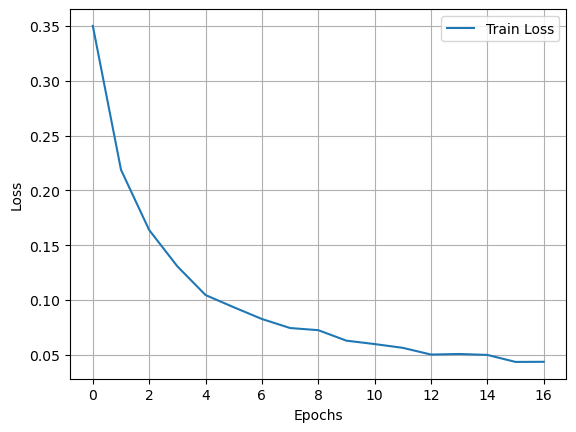

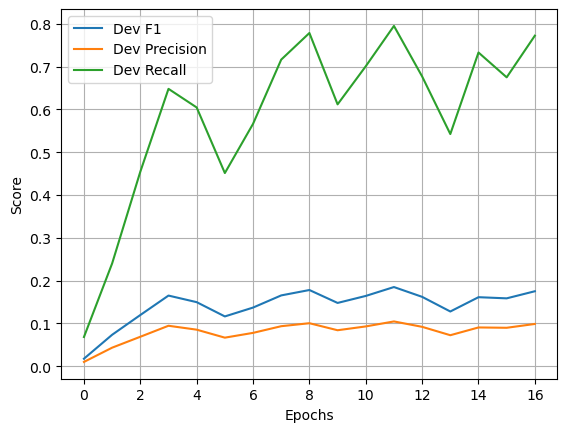

In [108]:
# TL1_0, DA1_0 = main_T5_likelihood(Train, Validate,
#                         tokeniser, model, device, n_epochs=20, 
#                         lr=10**(-4), early_stop=5, batch_size=32)

  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.325; dev F1: 0.188; dev Precision: 0.206, dev Recall: 0.173
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.198; dev F1: 0.398; dev Precision: 0.425, dev Recall: 0.374
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.146; dev F1: 0.500; dev Precision: 0.472, dev Recall: 0.531
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.110; dev F1: 0.537; dev Precision: 0.544, dev Recall: 0.531
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.092; dev F1: 0.515; dev Precision: 0.521, dev Recall: 0.510


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.083; dev F1: 0.575; dev Precision: 0.565, dev Recall: 0.586
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.070; dev F1: 0.574; dev Precision: 0.613, dev Recall: 0.540


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.069; dev F1: 0.539; dev Precision: 0.524, dev Recall: 0.554


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.058; dev F1: 0.565; dev Precision: 0.559, dev Recall: 0.570


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.059; dev F1: 0.561; dev Precision: 0.665, dev Recall: 0.486


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.048; dev F1: 0.517; dev Precision: 0.601, dev Recall: 0.454
Early stopping: no improvement for 5 epochs.


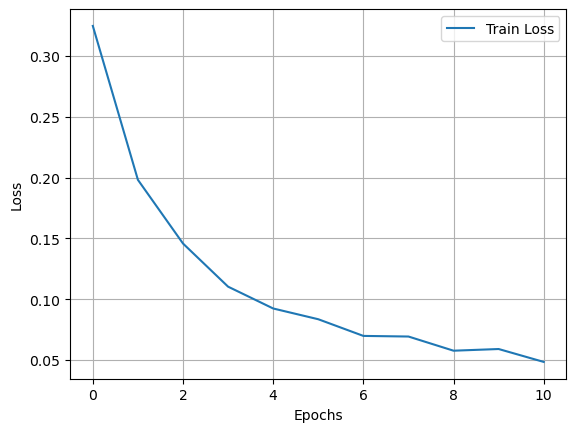

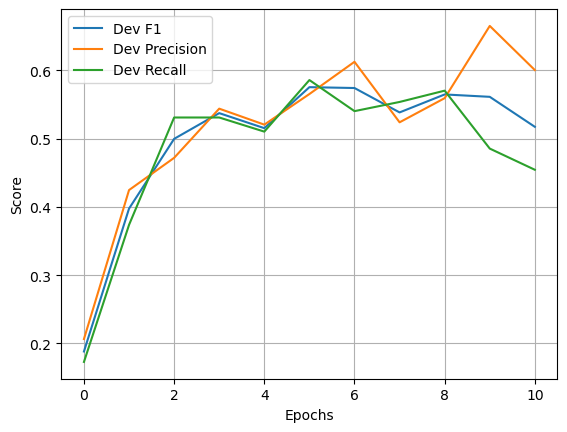

In [32]:
# TL1_1, DA1_1 = main_T5(Train, Validate,
#                        tokeniser, model, device, n_epochs=30, 
#                        lr=10**(-3), early_stop=5, batch_size=32)

  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.349; dev F1: 0.115; dev Precision: 0.168, dev Recall: 0.087
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.215; dev F1: 0.287; dev Precision: 0.313, dev Recall: 0.265
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.157; dev F1: 0.403; dev Precision: 0.404, dev Recall: 0.403
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.126; dev F1: 0.474; dev Precision: 0.466, dev Recall: 0.481
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.106; dev F1: 0.568; dev Precision: 0.552, dev Recall: 0.584
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.089; dev F1: 0.609; dev Precision: 0.606, dev Recall: 0.612
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.077; dev F1: 0.649; dev Precision: 0.644, dev Recall: 0.653
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.073; dev F1: 0.425; dev Precision: 0.432, dev Recall: 0.419


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.068; dev F1: 0.476; dev Precision: 0.480, dev Recall: 0.473


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.062; dev F1: 0.526; dev Precision: 0.528, dev Recall: 0.524


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.060; dev F1: 0.620; dev Precision: 0.620, dev Recall: 0.619


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.053; dev F1: 0.585; dev Precision: 0.592, dev Recall: 0.579


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.056; dev F1: 0.527; dev Precision: 0.528, dev Recall: 0.527


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13, train loss: 0.049; dev F1: 0.606; dev Precision: 0.621, dev Recall: 0.592


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14, train loss: 0.043; dev F1: 0.620; dev Precision: 0.632, dev Recall: 0.609
Early stopping: no improvement for 8 epochs.


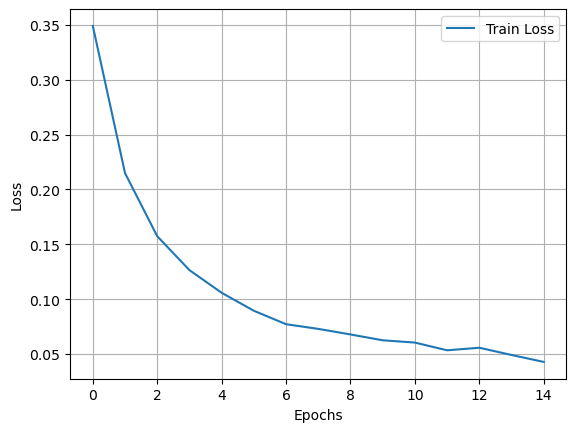

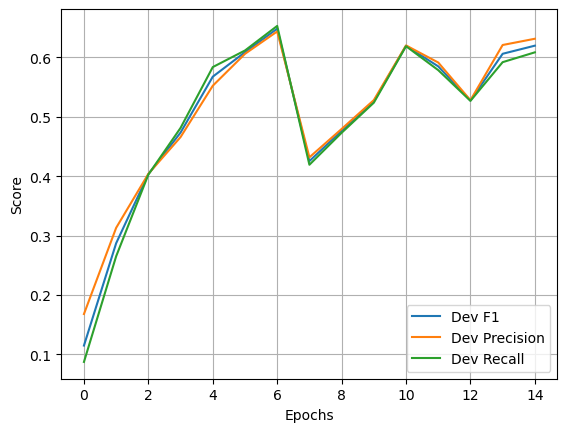

In [34]:
TL1_2, DA1_2 = main_T5(Train, Validate,
                       tokeniser, model, device, n_epochs=30, 
                       lr=10**(-4), early_stop=8, batch_size=32)

### 3-1-2. Simple tags 

In [37]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_tag, cache_dir='./hf_cache').to(device)
tokeniser = AutoTokenizer.from_pretrained(model_tag)

  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  0, train loss: 0.358; dev F1: 0.128; dev Precision: 0.383, dev Recall: 0.077
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1, train loss: 0.238; dev F1: 0.261; dev Precision: 0.330, dev Recall: 0.216
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2, train loss: 0.187; dev F1: 0.374; dev Precision: 0.394, dev Recall: 0.356
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3, train loss: 0.151; dev F1: 0.453; dev Precision: 0.427, dev Recall: 0.483
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4, train loss: 0.120; dev F1: 0.551; dev Precision: 0.522, dev Recall: 0.584
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5, train loss: 0.102; dev F1: 0.656; dev Precision: 0.632, dev Recall: 0.681
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6, train loss: 0.091; dev F1: 0.616; dev Precision: 0.597, dev Recall: 0.637


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7, train loss: 0.077; dev F1: 0.696; dev Precision: 0.679, dev Recall: 0.713
Saving the model


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8, train loss: 0.073; dev F1: 0.563; dev Precision: 0.557, dev Recall: 0.570


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9, train loss: 0.064; dev F1: 0.531; dev Precision: 0.522, dev Recall: 0.540


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, train loss: 0.064; dev F1: 0.456; dev Precision: 0.448, dev Recall: 0.464


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11, train loss: 0.059; dev F1: 0.519; dev Precision: 0.507, dev Recall: 0.531


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Validate:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12, train loss: 0.055; dev F1: 0.623; dev Precision: 0.605, dev Recall: 0.642
Early stopping: no improvement for 5 epochs.


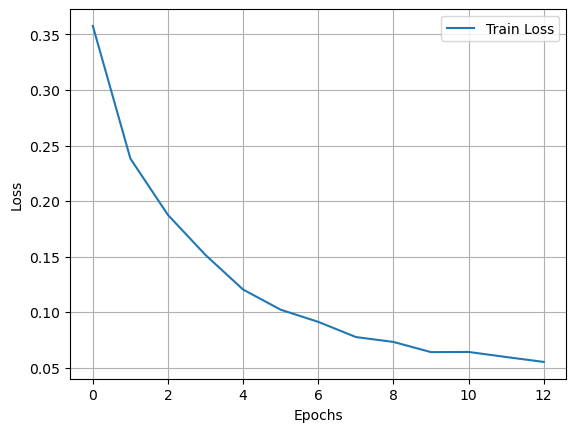

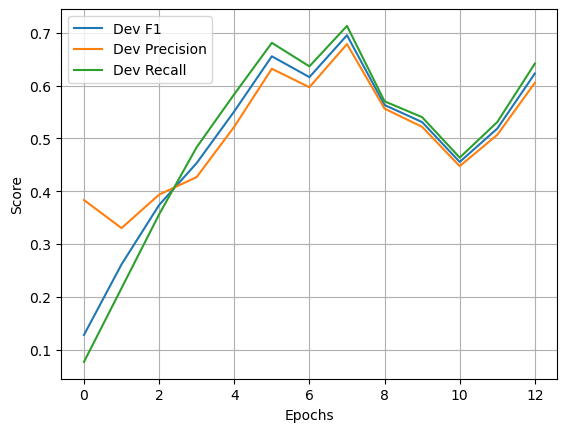

In [42]:
TL2_1, DA2_1 = main_T5(Simple_Train, Simple_Validate,
                       tokeniser, model, device, n_epochs=30, 
                       lr=10**(-4), early_stop=5, batch_size=32)

## 3-2. Test & OOD

### 3-2-1. Full tags

In [50]:
T5_Full_mod = load_checkpoint_T5("T5_Full_epoch07_4.pt", device, model)
batch_size=32

C:\Users\86138\AppData\Local\Temp\ipykernel_24060\855685083.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=device)


In [ ]:
Test_Full_Precision, Test_Full_Recall, Test_Full_F1 = validate_epoch_T5(Test, batch_size,
                                               tokeniser, T5_Full_mod, device, max_len=256)

print(f"Test_Full_F1: {Test_Full_F1*100:.1f}%, Test_Full_Precision: {Test_Full_Precision*100:.1f}%, Test_Full_Recall: {Test_Full_Recall*100:.1f}%")

Validate:   0%|          | 0/65 [00:00<?, ?it/s]

In [97]:
Test_result_T5 = evaluation_T5(Test, tokeniser, T5_Full_mod, 
                               device, tag_to_i, batch_size=32)
Test_result_T5

Test:   0%|          | 0/65 [00:00<?, ?it/s]

{'match_labelled': 0.6856617647058824,
 'match_unlabelled': 0.7205882352941176,
 'each_tag': {'LOC': {'precision': 0.64576802507837,
   'recall': 0.6498422712933754,
   'f1': 0.6477987421383647,
   'support': 317},
  'ORG': {'precision': 0.5307443365695793,
   'recall': 0.5093167701863354,
   'f1': 0.5198098256735341,
   'support': 322},
  'PER': {'precision': 0.7949260042283298,
   'recall': 0.8374164810690423,
   'f1': 0.8156182212581345,
   'support': 449}},
 'macro_P': 0.6571461219587597,
 'macro_R': 0.6655251741829177,
 'macro_F': 0.6610755963566778}

In [ ]:
OOD_Full_Precision, OOD_Full_Recall, OOD_Full_F1 = validate_epoch_T5(OOD, batch_size,
                                               tokeniser, T5_Full_mod, device, max_len=256)

print(f"OOD_Full_F1: {OOD_Full_F1*100:.1f}%, OOD_Full_Precision: {OOD_Full_Precision*100:.1f}%, OOD_Full_Recall: {OOD_Full_Recall*100:.1f}%")

In [98]:
OOD_result_T5 = evaluation_T5(OOD, tokeniser, T5_Full_mod, 
                              device, tag_to_i, batch_size=32)
OOD_result_T5

Test:   0%|          | 0/32 [00:00<?, ?it/s]

{'match_labelled': 0.5720930232558139,
 'match_unlabelled': 0.6362790697674419,
 'each_tag': {'LOC': {'precision': 0.5391498881431768,
   'recall': 0.5670588235294117,
   'f1': 0.5527522935779816,
   'support': 425},
  'ORG': {'precision': 0.625,
   'recall': 0.3617021276595745,
   'f1': 0.45822102425876016,
   'support': 235},
  'PER': {'precision': 0.6784037558685446,
   'recall': 0.6963855421686747,
   'f1': 0.6872770511296077,
   'support': 415}},
 'macro_P': 0.6141845480039071,
 'macro_R': 0.541715497785887,
 'macro_F': 0.5660834563221164}

### 3-2-2. Simple tags

In [43]:
T5_Simple_mod = load_checkpoint_T5("T5_Simple_epoch08_4.pt", device, model)

C:\Users\86138\AppData\Local\Temp\ipykernel_24060\855685083.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=device)


In [47]:
Test_Simple_Precision, Test_Simple_Recall, Test_Simple_F1 = validate_epoch_T5(Simple_Test, batch_size,
                                               tokeniser, T5_Simple_mod, device, max_len=256)

print(f"Test_Simple_F1: {Test_Simple_F1*100:.1f}%, Test_Simple_Precision: {Test_Simple_Precision*100:.1f}%, Test_Simple_Recall: {Test_Simple_Recall*100:.1f}%")

Validate:   0%|          | 0/65 [00:00<?, ?it/s]

Test_Simple_F1: 71.8%, Test_Simple_Precision: 70.0%, Test_Simple_Recall: 73.7%


In [48]:
Simple_Test_result_T5 = evaluation_Simple_T5(Simple_Test, tokeniser, T5_Simple_mod, 
                                             device, batch_size=32)
Simple_Test_result_T5

Test:   0%|          | 0/65 [00:00<?, ?it/s]

{'match_labelled': 0.7371323529411765,
 'match_unlabelled': 0.7371323529411765,
 'each_tag': {'_': {'precision': 0.7059859154929577,
   'recall': 0.7371323529411765,
   'f1': 0.721223021582734,
   'support': 1088}},
 'macro_P': 0.7059859154929577,
 'macro_R': 0.7371323529411765,
 'macro_F': 0.721223021582734}

In [49]:
OOD_Simple_Precision, OOD_Simple_Recall, OOD_Simple_F1 = validate_epoch_T5(Simple_OOD, batch_size,
                                               tokeniser, T5_Simple_mod, device, max_len=256)

print(f"OOD_Simple_F1: {OOD_Simple_F1*100:.1f}%, OOD_Simple_Precision: {OOD_Simple_Precision*100:.1f}%, OOD_Simple_Recall: {OOD_Simple_Recall*100:.1f}%")

Validate:   0%|          | 0/32 [00:00<?, ?it/s]

OOD_Simple_F1: 65.8%, OOD_Simple_Precision: 66.8%, OOD_Simple_Recall: 64.9%


In [104]:
Simple_OOD_result_T5 = evaluation_Simple_T5(Simple_OOD, tokeniser, T5_Simple_mod, 
                                             device, batch_size=32)
Simple_OOD_result_T5

Test:   0%|          | 0/32 [00:00<?, ?it/s]

{'match_labelled': 0.6493023255813953,
 'match_unlabelled': 0.6493023255813953,
 'each_tag': {'_': {'precision': 0.6717998075072185,
   'recall': 0.6493023255813953,
   'f1': 0.6603595080416274,
   'support': 1075}},
 'macro_P': 0.6717998075072185,
 'macro_R': 0.6493023255813953,
 'macro_F': 0.6603595080416274}